## Predicting Crashes in Financial Markets - RNN LSTM (Stateless)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
from prepare_data_RNN import DataLoader
from evaluate_results import EvaluateResults

In [2]:
# -------------------- data preparation -------------------- #
os.chdir('/content/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv', '^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
# crashes according to Jacobsson:
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344]
# crashes according to Sornette:
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264]
datasets_revised, crashes = data.get_data_revised(crash_thresholds)

months = [1, 3, 6]     # <-- predict if crash n months ahead
sequence = 10          # <-- number of days lookback as input(only if select_features=False)
additional_feat = True # <-- add mean price change and vol for 4 time widnows over 252 days
batch_size = 60        # <-- batch size needs to be specified to satisfy stateful=True
dfs_x1, dfs_x2, dfs_y = data.get_df_xy(months=months, sequence=sequence, \
                            batch_size=batch_size, additional_feat=additional_feat)

In [3]:
# -------------------- RNN LSTM model -------------------- #
model_name = 'RNN LSTM'
neurons = 50
dropout = 0
optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'sigmoid'
inp_dim = 2   # <-- 1 if price change only, 2 if volatility as well
inp_tsteps = sequence + 4 * additional_feat
def rnn_lstm(inp_tsteps, inp_dim, neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inp_tsteps, inp_dim), return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dense(3, activation=activation))
    return model
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 30953 (120.91 KB)
Trainable params: 30953 (120.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# -------------------- Train and test RNN LSTM model -------------------- #
epochs = 20
os.chdir('/content/models/model_weights/')
test_data = 'S&P 500'
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x1_training = list(dfs_x1)
dfs_x1_training.pop(index_test)
dfs_x2_training = list(dfs_x2)
dfs_x2_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)

for val_data in training_set_names:
    model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    np_x1_train, np_x2_train, np_y_train, _, _, _ = data.get_train_test(dfs_x1_training,\
            dfs_x2_training, dfs_y_training, training_set_names, test_data=val_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    for e in range(epochs):
        model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=True)
        if (e + 1) % 2 == 0:
            model.save_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(val_data, e + 1))

Train RNN LSTM - validation data: N225
Train RNN LSTM - validation data: SSE
Train RNN LSTM - validation data: HSI
Train RNN LSTM - validation data: BSESN
Train RNN LSTM - validation data: SMI
Train RNN LSTM - validation data: BVSP


In [5]:
# -------------------- Load weights and predict results -------------------- #
os.chdir('/content/models/model_weights/')
epoch = 10 # <-- change to load model weights from previous epochs
y_train_all, y_val_all = [], []
y_pred_train_all, y_pred_val_all = [], []
for val_data in training_set_names:
    np_x1_train, np_x2_train, np_y_train, np_x1_val, np_x2_val, np_y_val = \
        data.get_train_test(dfs_x1_training, dfs_x2_training, dfs_y_training, \
                training_set_names, test_data=val_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    np_x_val = np.concatenate([np_x1_val, np_x2_val], axis=2)
    y_train_all.append(np_y_train)
    y_val_all.append(np_y_val)
    model.load_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(val_data, epoch))
    y_pred_train = model.predict(np_x_train, batch_size=batch_size, verbose=True)
    y_pred_train_all.append(y_pred_train)
    y_pred_val = model.predict(np_x_val, batch_size=batch_size, verbose=True)
    y_pred_val_all.append(y_pred_val)

84/84 [==============================] - 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

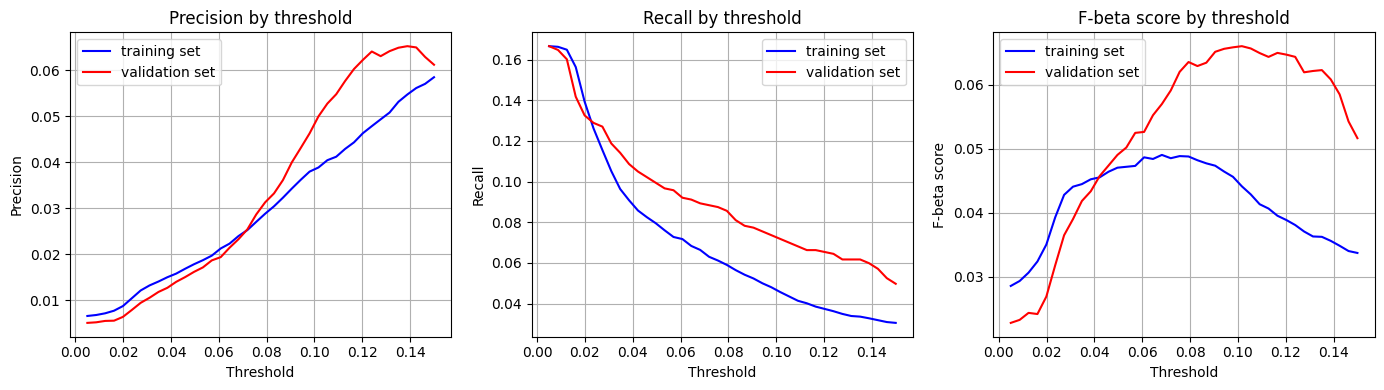

In [6]:
# -------------------- Find best threshold -------------------- #
month_prediction = 3
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
y_train_all_ = [y[:, index_month] for y in y_train_all]
y_val_all_ = [y[:, index_month] for y in y_val_all]
y_pred_train_all_ = [y[:, index_month] for y in y_pred_train_all]
y_pred_val_all_ = [y[:, index_month] for y in y_pred_val_all]
beta = 2
rcParams['figure.figsize'] = 14, 4
eval_ = EvaluateResults(y_train_all_, y_val_all_, y_pred_train_all_, y_pred_val_all_, model_name, test_data)
eval_.find_threshold(beta=beta, threshold_min=0.005, threshold_max=0.15, resolution=40)

In [7]:
# -------------------- Evaluate results -------------------- #
threshold = 0.07
beta = 2
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_x1[0].shape[1] + dfs_x2[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_val_all[0])))
print('Number of epochs:               ' + str(epoch))
print('Sequence length:                ' + str(sequence))
print('Number of neurons/layer:        ' + str(neurons))
print('Batch size:                     ' + str(batch_size))
print('Optimizer:                      ' + str(optimizer))
print('Loss function:                  ' + str(loss))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

RNN LSTM


Predict crash in:               3 months
Threshold for positives:        0.07
Number of features:             28
Number of rows in training set: 48000
Number of epochs:               10
Sequence length:                10
Number of neurons/layer:        50
Batch size:                     60
Optimizer:                      adam
Loss function:                  binary_crossentropy




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Results for each train/val split:
                       N225   SSE   HSI  BSESN   SMI  BVSP
positive actual train  0.03  0.04  0.04   0.04  0.04  0.04
positive pred train    0.00  0.10  0.00   0.00  0.00  0.00
precision train        0.00  0.15  0.00   0.00  0.00  0.00
recall train           0.00  0.39  0.00   0.00  0.00  0.00
accuracy_train         0.97  0.89  0.96   0.96  0.96  0.96
score_fbeta train      0.00  0.29  0.00   0.00  0.00  0.00
positive actual val    0.05  0.03  0.03   0.04  0.05  0.01
positive pred val      0.00  0.11  0.00   0.00  0.00  0.00
precision val          0.00  0.15  0.00   0.00  0.00  0.00
recall val             0.00  0.54  0.00   0.00  0.00  0.00
accuracy val           0.95  0.89  0.97   0.96  0.95  0.99
score fbeta val        0.00  0.35  0.00   0.00  0.00  0.00


Results - average over all train/val splits:
Positive train cases actual:            0.04
Positive train cases predicted:         0.02
Avg precision train (model/random):     0.02 / 0.04
Avg recall

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# -------------------- Train model on all training data for testing -------------------- #
test_data = 'S&P 500'
np_x1_train, np_x2_train, np_y_train, np_x1_test, np_x2_test, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
epochs = 10
os.chdir('/content/models/model_weights/')
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
print('Train model for testing ' + str(model_name) + ' - test data: ' + str(test_data))
for e in range(epochs):
    model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)
    if (e + 1) % 2 == 0:
        model.save_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(test_data, e + 1))

Train model for testing RNN LSTM - test data: S&P 500
800/800 [==============================] - 14s 17ms/step - loss: nan - accuracy: 0.9436


In [9]:
# -------------------- Test model -------------------- #
test_data = 'S&P 500'
epoch = 10
threshold=0.07
month_prediction = 3   # <-- predict crash in 1, 3 or 6 months
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
_, _, _, np_x1_test, np_x2_test, np_y_test = \
    data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)
model.load_weights('stateless_s10_2d_bce_{0}_{1}.hdf5'.format(test_data, epoch))
y_pred_test = model.predict(np_x_test, batch_size=batch_size)[:, index_month]
y_test = np_y_test[:, index_month]
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

303/303 [==============================] - 3s 7ms/step
Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.0
Precision test (model/random):      0.0 / nan
Recall test (model/random):         0.0 / 0.0
Accuracy test (model/random):       0.96 / 0.96
Score test fbeta:                   0.0 / nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/evaluate_results.py:208: RuntimeWarning: invalid value encountered in scalar divide
  rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)


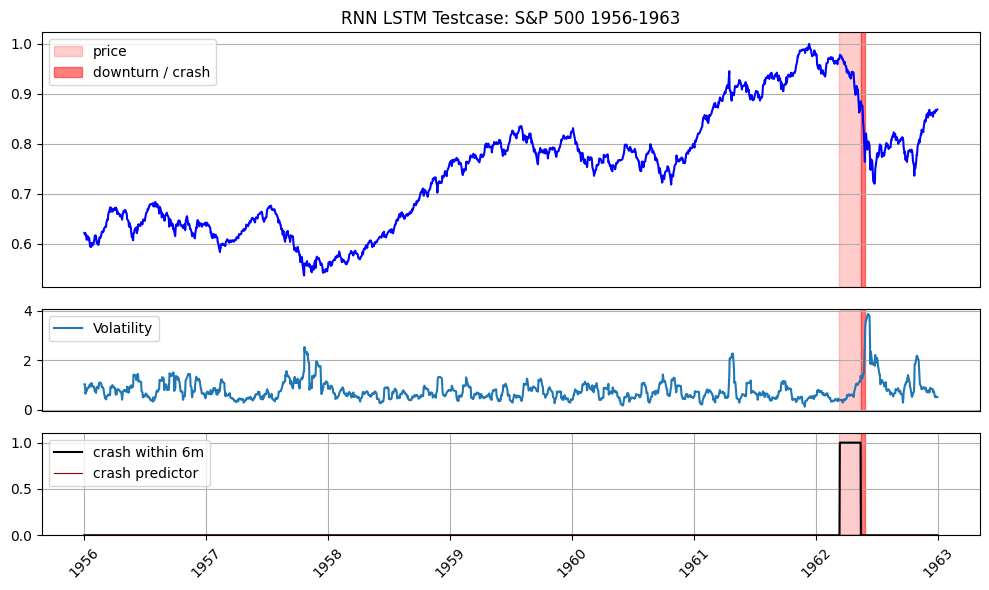

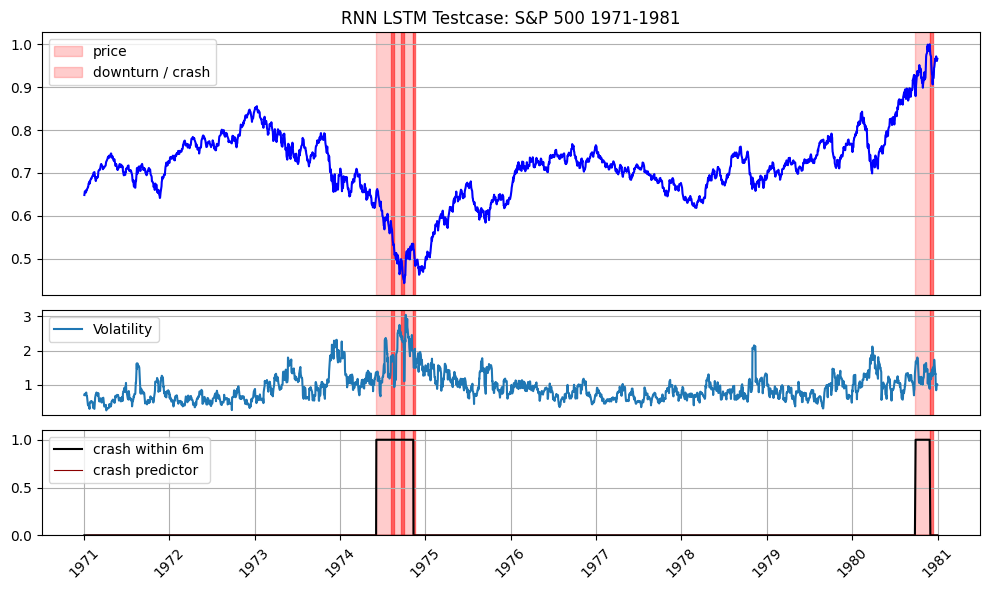

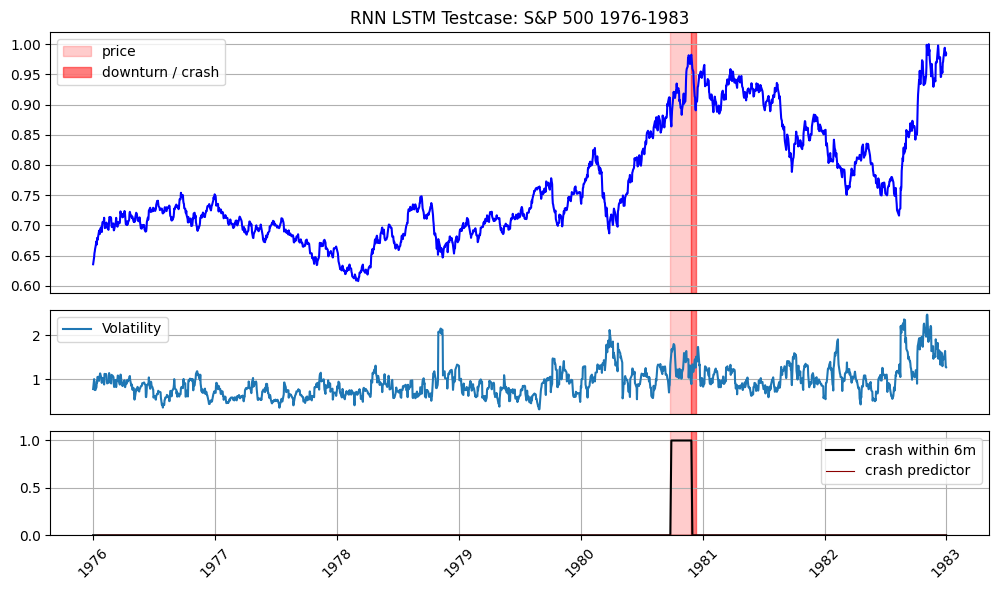

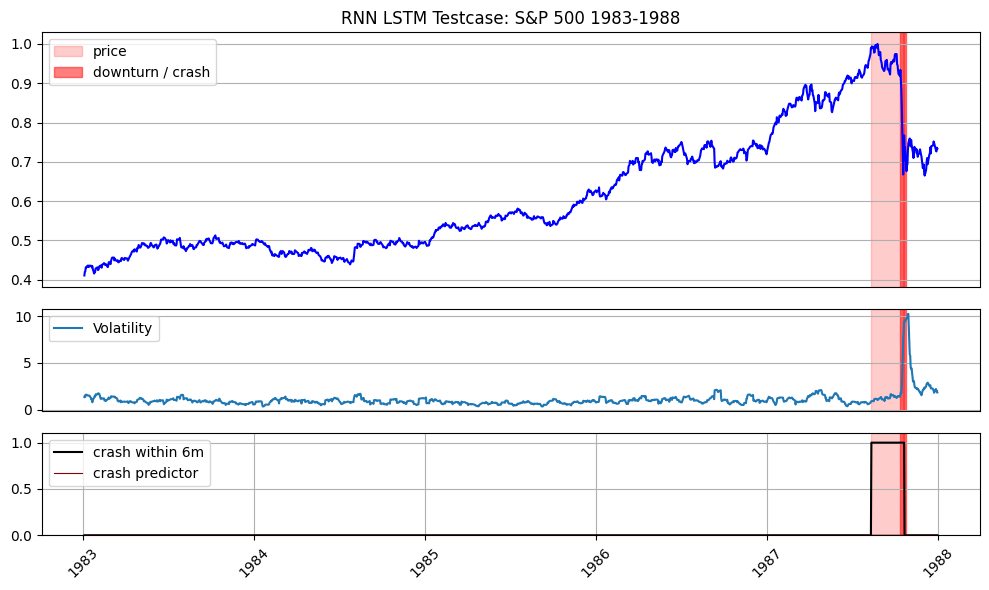

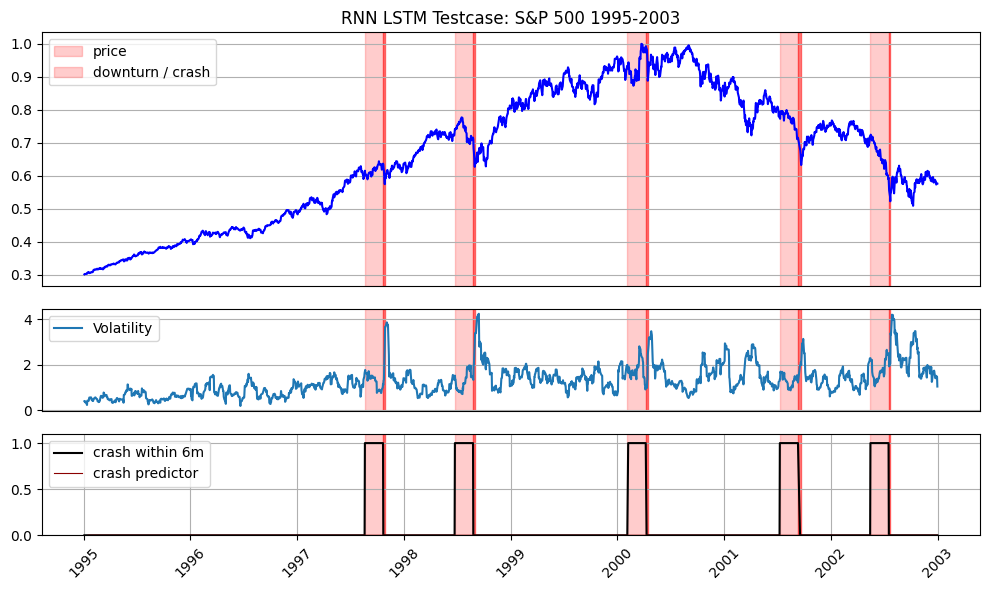

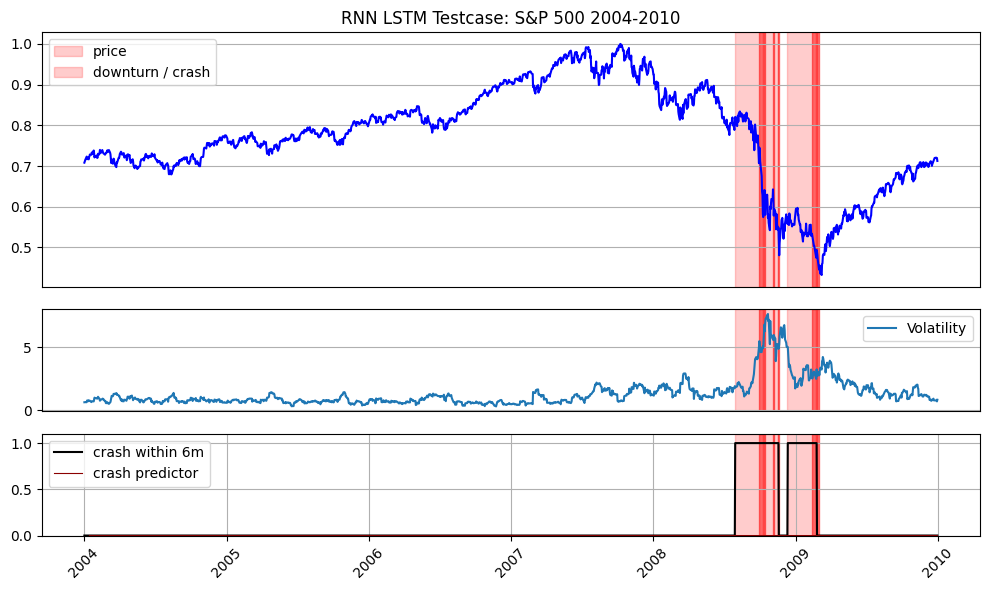

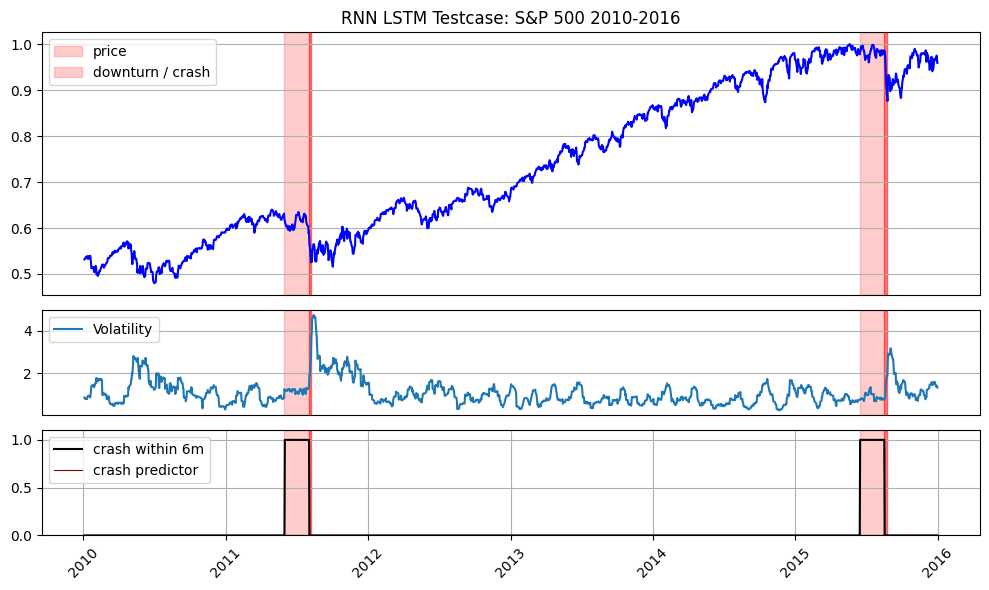

In [10]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x1[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)